# Setup

## Import

In [2]:
from pyfk import SourceModel, SeisModel, Config
from pyfk import calculate_gf
from pyfk import calculate_sync
from pyfk import generate_source_time_function

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from obspy.geodetics import gps2dist_azimuth, locations2degrees, kilometers2degrees
from obspy import UTCDateTime
from obspy.taup import TauPyModel

from dataclasses import dataclass
from typing import List
import logging
from scipy.fft import fft, fftfreq
from multiprocessing import process
import sys

print("PyFK and other classes imported successfully!")

PyFK and other classes imported successfully!


## Modify parameters

In [3]:
@dataclass
class SimulationConfig:
    """Configuration class for simulation parameters"""
    
    # MODIFY: Main parameters
    source_depths = np.arange(15, 96, 10)
    receiver_distances = np.arange(100, 2001, 100) 
    
    # MODIFY: Source parameters
    magnitude = 6
    strike = 90
    dip = 45
    rake = 90
    azimuth = 45

    # MODIFY: GF parameters
    npt = 5100
    dt = .1

    # MODIFY: STF parameters
    fix_duration = 4.2
    fix_rise = 0.1
    fix_STF = True # set to True to use fixed STF parameters, False to use recommended STF parameters (only if using Ricker wavelet)
    n_cycles = 3 # number of dominant frequency cycles covered by STF (only if using Ricker wavelet)
    
    # MODIFY: Filtering parameters (Try [0.02-0.1] [0.05-0.2] [0.1-0.5] [0.2-1] [0.5-2][1-4])
    Sn_freqmin = 0.25 # for SnLg
    Sn_freqmax = 1.0 # for SnLg
    Lg_freqmin = 0.25 # for SnLg
    Lg_freqmax = 1.0 # for SnLg
    plot_freqmin = 0.25 # for synthetic plotting
    plot_freqmax = 1.0 # for synthetic plotting
    plot_corners = 4 # for synthetic plotting

    # Additional parameters
    vsm=4.9 # for SnLg
    vsc=3.9 # for SnLg
    moho=[70.0] # for SnLg
    sync_origintime = UTCDateTime('2021-04-28T02:21:26.196000Z') # arbitrary
    sync_longitude = -122.168861 # arbitrary
    sync_latitude = 37.428230 # arbitrary
    baz = (azimuth + 180) % 360 # auto-calculated

    # Model parameters
    layer1_thickness = 3.0
    layer1_vs = 3.3
    layer1_vp = 5.8
    layer1_rho = 2.3
    layer1_q1 = 50
    layer1_q2 = 100
    
    layer2_thickness = 37.0
    layer2_vs = 3.5
    layer2_vp = 5.8
    layer2_rho = 2.8
    layer2_q1 = 200
    layer2_q2 = 400
    
    layer3_thickness = 30.0
    layer3_vs = 4.0
    layer3_vp = 6.9
    layer3_rho = 3.0
    layer3_q1 = 200
    layer3_q2 = 400
    
    layer4_thickness = 500.0
    layer4_vs = 4.9
    layer4_vp = 8.6
    layer4_rho = 3.3
    layer4_q1 = 600
    layer4_q2 = 1200
    
    def get_mechanism(self) -> List[float]:
        return [self.magnitude, self.strike, self.dip, self.rake]

    def get_model_data(self):
        return np.array([
            [self.layer1_thickness, self.layer1_vs, self.layer1_vp, self.layer1_rho, self.layer1_q1, self.layer1_q2],  # 0-3 km
            [self.layer2_thickness, self.layer2_vs, self.layer2_vp, self.layer2_rho, self.layer2_q1, self.layer2_q2],  # 3-40 km  
            [self.layer3_thickness, self.layer3_vs, self.layer3_vp, self.layer3_rho, self.layer3_q1, self.layer3_q2],  # 40-70 km
            [self.layer4_thickness, self.layer4_vs, self.layer4_vp, self.layer4_rho, self.layer4_q1, self.layer4_q2],  # >70 km (to 500 km)
        ])

# Create configuration instance
parameters = SimulationConfig()
print("Config created successfully!")
print("Source depths: ", parameters.source_depths)
print("Receiver distances: ", parameters.receiver_distances)

Config created successfully!
Source depths:  [15 25 35 45 55 65 75 85 95]
Receiver distances:  [ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300 1400
 1500 1600 1700 1800 1900 2000]


## Define models

In [4]:
# Create seismic model
model_data = parameters.get_model_data()
model = SeisModel(model=model_data, flattening = False)

# Create sources array
def setup_source(parameters, i):
    """Setup a source at a given depth (i)"""
    # Create source model
    source = SourceModel(
        sdep=parameters.source_depths[i],
        srcType="dc",
        source_mechanism=parameters.get_mechanism()
    )
    print(f"Source {i}:", source)
    return source
print("Creating sources array...")
sources = []
for i in range(len(parameters.source_depths)):
    source = setup_source(parameters, i)
    sources.append(source)

# Create configs array
def setup_config(model, source, parameters):
    """Setup configuration object for a given source; with error handling"""
    try:
        
        config_obj = Config(
            model=model,
            source=source,
            npt=parameters.npt,
            dt=parameters.dt,
            receiver_distance=np.array(parameters.receiver_distances)
        )
        print(f"Config {i}:", config_obj)
        return config_obj

    except Exception as e:
        logging.error(f"Error setting up configuration: {e}")
        raise
print("Creating configs array...")
configs = []
for i in range(len(sources)):
    config_obj= setup_config(model, sources[i], parameters)
    configs.append(config_obj)

Creating sources array...
Source 0: SourceModel(sdep=15, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 1: SourceModel(sdep=25, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 2: SourceModel(sdep=35, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 3: SourceModel(sdep=45, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 4: SourceModel(sdep=55, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 5: SourceModel(sdep=65, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 6: SourceModel(sdep=75, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 7: SourceModel(sdep=85, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 8: SourceModel(sdep=95, srcType=dc, source_mechanism=[ 6 90 45 90])
Creating configs array...
Config 0: Config(model=SeisModel(layers=5, flattening=False), source=SourceModel(sdep=15, srcType=dc, source_mechanism=[ 6 90 45 90]), receiver_distance=[ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000. 1100. 1200.
 1300. 1400. 1500. 1600. 1700. 1800. 1900. 2000

# Calculate Green's functions

In [5]:
# gfs = []

# for i in range(len(configs)):
#     config = configs[i]
#     gf = calculate_gf(config)
#     gfs.append(gf)
#     print('Calculated Green\'s function for source depth: ' + str(int(parameters.source_depths[i])).zfill(2) + 'km')

# print("----------------Structure of gfs----------------")
# print("gfs is an array; length equal to # of depths: \n", (gfs))
# print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
# print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

## Read/save Green's functions

In [6]:
import os
from glob import glob
import obspy

def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each depth is saved in a separate folder.
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    N = len(gfs) # Number of depths
    for i in range(N):
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each depth
        gf_w = gfs[i] # Streams for given depth, one for each receiver distance
        for j in range(len(gf_w)): # Loop over stream for given depth and receiver distance
            gf_w[j].write(path + '/' + str(i).zfill(2) + "/grn_" + str(j).zfill(3) + "_.sac", format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns a nested list of obspy Stream objects.
    """
    GF = []
    dirs = glob(path + '/*')
    dirs.sort()
    for dir in dirs:
        GFn = []
        files = glob(dir + '/*_01.sac')
        files.sort()
        for file in files:
            # Read all matching SAC files for this Green's function
            stream = obspy.read(file[:-5] + '*')
            GFn.append(stream)
        GF.append(GFn)
    return GF

In [7]:
# Folder Bulk_gfs, subfolder 01, file grn_001_06 indicates 2nd depth (01, 0 index), 2nd receiver (001, 0 index), 6th trace (06, 1 index)
# saveGF('Investigate_gfs', gfs)
gfs = readGF('Bulk_gfs_unflattened')

print("----------------Structure of gfs----------------")
print("gfs is an array; length equal to # of depths: \n", (gfs))
print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

----------------Structure of gfs----------------
gfs is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x120757130>, <obspy.core.stream.Stream object at 0x1207946d0>, <obspy.core.stream.Stream object at 0x1205c3160>, <obspy.core.stream.Stream object at 0x12079d790>, <obspy.core.stream.Stream object at 0x12079f940>, <obspy.core.stream.Stream object at 0x12079fe50>, <obspy.core.stream.Stream object at 0x1207a9970>, <obspy.core.stream.Stream object at 0x1207a8040>, <obspy.core.stream.Stream object at 0x1207b65e0>, <obspy.core.stream.Stream object at 0x1207b2a00>, <obspy.core.stream.Stream object at 0x1207be6d0>, <obspy.core.stream.Stream object at 0x1207c0b20>, <obspy.core.stream.Stream object at 0x1207c3cd0>, <obspy.core.stream.Stream object at 0x1207cc760>, <obspy.core.stream.Stream object at 0x1207c8b80>, <obspy.core.stream.Stream object at 0x1207d3850>, <obspy.core.stream.Stream object at 0x1207d29a0>, <obspy.core.stream.Stream object at 0x1207d4c40>, <

# Generate STF

In [8]:
def get_ricker_stf_params(filter_min, filter_max, n_cycles):
    """
    Given filter band (Hz), return recommended rise and duration for Ricker STF.
    """
    center_freq = (filter_min + filter_max) / 2
    rise = 1.0 / (3.0 * center_freq) # Specific to a Ricker wavelet
    duration = n_cycles / center_freq
    return duration, rise

dura_rec, rise_rec = get_ricker_stf_params(parameters.plot_freqmin, parameters.plot_freqmax, parameters.n_cycles)
print(f"Recommended parameters for filter band {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz (if Ricker wavelet): {dura_rec:.2f} s, rise: {rise_rec:.2f} s")

Recommended parameters for filter band 0.25 - 1.0 Hz (if Ricker wavelet): 4.80 s, rise: 0.53 s


In [9]:
# ------ Parameters
delta = parameters.dt

if parameters.fix_STF:
    dura = parameters.fix_duration
    rise = parameters.fix_rise
else:
    dura = dura_rec
    rise = rise_rec

# # ------ Triangular
# source_time_function = generate_source_time_function(dura=dura, rise=rise, delta=delta)
# print("Triangular source time function generated.")

# # ------ Ricker wavelet
# from obspy import Trace
# def generate_source_time_function2(
#         dura: float = 1.0,
#         rise: float = 1.0,  # Increase rise time to lower dominant frequency
#         delta: float = 0.1) -> Trace:
#     """
#     Generate a Ricker wavelet source time function with smooth frequency spectrum
#     """
#     ns = int(dura / delta)
#     if ns < 2:
#         ns = 2
    
#     # Create time array
#     t = np.arange(0, dura + delta, delta)
#     center = dura / 2
    
#     # Use rise time to determine dominant frequency
#     # Longer rise time = lower frequency
#     dominant_freq = 1.0 / (3.0 * rise)  # Reduced from 2.0 to 3.0
    
#     # Generate Ricker wavelet
#     arg = np.pi * dominant_freq * (t - center)
#     result_data = (1 - 2 * arg**2) * np.exp(-arg**2)
    
#     # Normalize
#     result_data = result_data / np.max(np.abs(result_data))
    
#     result_trace = Trace(header={}, data=result_data)
#     result_trace.stats.delta = delta
#     return result_trace
# source_time_function = generate_source_time_function2(dura=dura, rise=rise, delta=delta)
# print("Ricker source time function generated.")

# ------ Trapezoidal
from obspy import Trace
def generate_source_time_function3(
        total_duration: float = 4.2,
        rise_time: float = 0.1,
        base_time: float = 4.0,
        delta: float = 0.1) -> Trace:
    """
    Generate a trapezoidal source time function.
    """
    # Validate inputs
    if 2 * rise_time + base_time > total_duration:
        raise ValueError("2*rise_time + base_time cannot exceed total_duration")
    
    # Calculate number of points
    ns = int(total_duration / delta)
    nr = int(rise_time / delta)  # points for rise
    nb = int(base_time / delta)  # points for base
    
    # Create time array
    t = np.arange(0, total_duration + delta, delta)
    
    # Initialize STF array
    stf = np.zeros_like(t)
    
    # Ramp up (0 to 1)
    if nr > 0:
        stf[:nr] = np.linspace(0, 1, nr)
    
    # Flat top (constant = 1)
    if nb > 0:
        stf[nr:nr+nb] = 1.0
    
    # Ramp down (1 to 0)
    if nr > 0:
        stf[nr+nb:nr+nb+nr] = np.linspace(1, 0, nr)
    
    # Normalize
    stf = stf / np.max(stf)
    
    # Create ObsPy Trace
    result_trace = Trace(header={}, data=stf)
    result_trace.stats.delta = delta
    
    return result_trace
source_time_function = generate_source_time_function3(total_duration=dura, rise_time=rise, base_time=dura-2*rise, delta=delta)
print("Trapezoidal source time function generated.")

# # ------ Gaussian
# from obspy import Trace
# def generate_source_time_function4(
#         duration: float = 0.4,
#         sigma: float = None,  # Made optional
#         delta: float = 0.1) -> Trace:
#     """
#     Generate a Gaussian source time function.
#     """
    
#     # Set default sigma if not provided
#     if sigma is None:
#         sigma = duration / 6  # This gives a reasonable width
    
#     # Calculate number of points
#     ns = int(duration / delta)
#     if ns < 2:
#         ns = 2
    
#     # Create time array centered at duration/2
#     t = np.arange(0, duration + delta, delta)
#     center = duration / 2
    
#     # Generate Gaussian function
#     stf = np.exp(-0.5 * ((t - center) / sigma)**2)
    
#     # Normalize to maximum amplitude of 1
#     stf = stf / np.max(stf)
    
#     # Create ObsPy Trace
#     result_trace = Trace(header={}, data=stf)
#     result_trace.stats.delta = delta
    
#     return result_trace
# source_time_function = generate_source_time_function4(duration=dura, delta=delta)
# print("Gaussian source time function generated.")

Trapezoidal source time function generated.


## Plot STF with filter band

Frequencies above 10% max: 0.23 to 4.65 Hz


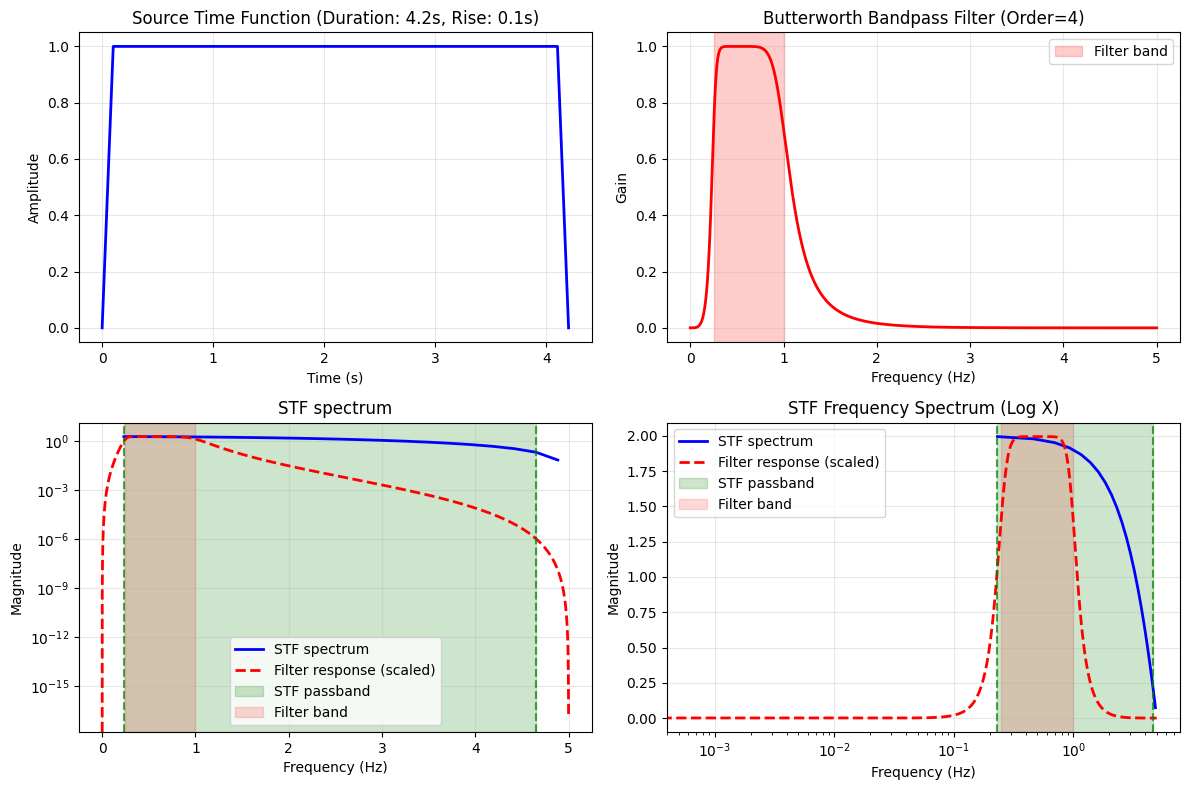

STF duration: 4.2 seconds
STF passband: 0.23-4.65 Hz
Filter band: 0.25-1.0 Hz


In [10]:
# Calculate frequency spectrum
n = len(source_time_function)  # Get the number of points in the STF
freq = fftfreq(n, delta)       # Create frequency axis from -Nyquist to +Nyquist (Hz)
fft_stf = fft(source_time_function)  # Convert STF from time domain to frequency domain
magnitude = np.abs(fft_stf)    # Get the amplitude (magnitude) at each frequency

# Frequency domain: get positive frequencies and their magnitudes
positive_freq_mask = freq > 0  # Create mask for positive frequencies only
freq_pos = freq[positive_freq_mask]
mag_pos = magnitude[positive_freq_mask]

# ------Find cutoff frequencies
max_amp = np.max(mag_pos)
threshold = 0.1 * max_amp

# Find all indices where magnitude is above threshold
above_10_mask = mag_pos >= threshold
if np.any(above_10_mask):
    # Get all frequencies above threshold
    freqs_above = freq_pos[above_10_mask]
    print(f"Frequencies above 10% max: {freqs_above[0]:.2f} to {freqs_above[-1]:.2f} Hz")
    # Set low and high cutoff
    low_cutoff_freq = freqs_above[0]
    high_cutoff_freq = freqs_above[-1]
else:
    print("WARNING: No frequencies above 10% of max amplitude.")
    low_cutoff_freq = None
    high_cutoff_freq = None

# ------Plot filter, STF and frequency spectrum for both
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]  # Top left
ax2 = axes[0, 1]  # Top right
ax3 = axes[1, 0]  # Bottom left
ax4 = axes[1, 1]  # Bottom right

# ---Time domain
time_stf = np.arange(len(source_time_function)) * delta  # Create time axis (seconds)
ax1.plot(time_stf, source_time_function, 'b-', linewidth=2)  # Plot STF in time domain
ax1.set_title(f'Source Time Function (Duration: {dura}s, Rise: {rise}s)')  # Set title with parameters
ax1.set_xlabel('Time (s)')     # Label x-axis
ax1.set_ylabel('Amplitude')    # Label y-axis
ax1.grid(True, alpha=0.3)      # Add grid with transparency

# ---Filter parameters (from parameters)
from scipy.signal import butter, freqz
# Filter parameters
freqmin = parameters.plot_freqmin
freqmax = parameters.plot_freqmax
corners = 4
fs = 1.0 / parameters.dt  # Sampling frequency
# Design Butterworth bandpass filter
nyq = 0.5 * fs  # Calculate the Nyquist frequency (half the sampling rate)
low = freqmin / nyq  # Normalize the lower cutoff frequency (as a fraction of Nyquist)
high = freqmax / nyq  # Normalize the upper cutoff frequency (as a fraction of Nyquist)
b, a = butter(corners, [low, high], btype='band')  
# Design a Butterworth bandpass filter of order 'corners' with normalized cutoff frequencies.
# 'b' and 'a' are the filter coefficients for the numerator and denominator, respectively.
w, h = freqz(b, a, worN=8000)  
# Compute the frequency response of the filter.
# 'w' is an array of frequencies (in radians/sample), 'h' is the complex frequency response.
f = w * fs / (2 * np.pi)  
# Convert the frequency array 'w' from radians/sample to Hz for plotting.
# Plotting
ax2.plot(f, abs(h), 'r', linewidth=2)
ax2.set_title(f'Butterworth Bandpass Filter (Order={corners})')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Gain')
ax2.grid(True, alpha=0.3)
ax2.axvspan(freqmin, freqmax, color='red', alpha=0.2, label='Filter band')
ax2.legend()

# ---Frequency domain (log y-axis)
ax3.semilogy(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax3.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax3.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax3.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax3.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax3.set_title('STF spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.grid(True, alpha=0.3)
ax3.legend()


# ---Frequency domain (log x-axis)
ax4.semilogx(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax4.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax4.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7)
ax4.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax4.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax4.set_title('STF Frequency Spectrum (Log X)')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"STF duration: {dura} seconds")
print(f"STF passband: {low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz")
print(f"Filter band: {freqmin}-{freqmax} Hz")

# Calculate synthetics

In [11]:
sync_results = []
for i in range(len(gfs)): # loop over depths
    sync_result = calculate_sync(gfs[i], configs[i], parameters.azimuth, source_time_function) # calculate sync for given depth, all receivers
    sync_results.append(sync_result)
    print(f"Calculated synthetic seismograms for depth {i}: {sync_result}")

print("----------------Structure of sync_results----------------")
print("sync_results is an array; length equal to # of depths: \n", sync_results)
print("sync_results[0] are the streams for 1st depth; length equal to # of receivers: \n", sync_results[0])
print("sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: \n", sync_results[0][0]) 

for i in range(len(sync_results)):
    for j in range(len(sync_results[i])):
        selected_sync = sync_results[i][j] # stream for given depth (i) and receiver distance (j)
        # Assign channel codes to synthetic traces (Z, R, T components)
        channel_codes = ['BHZ', 'BHR', 'BHT'] 
        for k, tr in enumerate(selected_sync):
            tr.stats.channel = channel_codes[k]
        # Set synthetic trace to start at correct time (accounting for shift)
        for tr in selected_sync:
            tr.stats.starttime = parameters.sync_origintime + tr.stats.sac.b

Calculated synthetic seismograms for depth 0: [<obspy.core.stream.Stream object at 0x120780c10>, <obspy.core.stream.Stream object at 0x10442bd90>, <obspy.core.stream.Stream object at 0x15fa36340>, <obspy.core.stream.Stream object at 0x15fae3220>, <obspy.core.stream.Stream object at 0x15fc22310>, <obspy.core.stream.Stream object at 0x15fc228b0>, <obspy.core.stream.Stream object at 0x15fc2e190>, <obspy.core.stream.Stream object at 0x15fc2e730>, <obspy.core.stream.Stream object at 0x15fc2ee50>, <obspy.core.stream.Stream object at 0x15fc305b0>, <obspy.core.stream.Stream object at 0x15fc30cd0>, <obspy.core.stream.Stream object at 0x15fc33430>, <obspy.core.stream.Stream object at 0x15fc33b50>, <obspy.core.stream.Stream object at 0x15fc352b0>, <obspy.core.stream.Stream object at 0x15fc359d0>, <obspy.core.stream.Stream object at 0x15fc38130>, <obspy.core.stream.Stream object at 0x15fc38850>, <obspy.core.stream.Stream object at 0x15fc3b130>, <obspy.core.stream.Stream object at 0x15fc3b6d0>, <ob

# Run SnLg on synthetics

In [12]:
sys.path.append("/Users/emmanuelzheng/Downloads/Synthetics")

# --- 1. Imports ---
from SnLg.snlg_analyses import SnLg_Analyses, SnLg_OneEventStationPair
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import copy

# --- 2. Prepare synthetic waveforms ---
sync_SnLg = copy.deepcopy(sync_results)
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):
        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        selected_sync.rotate('RT->NE', back_azimuth=parameters.baz) # rotate to ZNE

# --- BEGIN CALCULATING SnLg FOR ALL WAVEFORMS AT THIS POINT ---
results = []
for i in range(len(sync_SnLg)):
    for j in range(len(sync_SnLg[i])):

        selected_sync = sync_SnLg[i][j] # stream for given depth (i) and receiver distance (j)
        depth = parameters.source_depths[i]
        receiver_distance = parameters.receiver_distances[j]

        # --- 3. Prepare event data ---
        from collections import namedtuple
        Event = namedtuple('Event', ['event_lat', 'event_lon', 'event_dep', 'event_time', 'event_mag'])
        event = Event(
            event_lat=parameters.sync_latitude,
            event_lon=parameters.sync_longitude,
            event_dep=depth,
            event_time=parameters.sync_origintime,
            event_mag=parameters.magnitude
        )

        # --- 4. Calculate other required parameters ---
        gcarc = kilometer2degrees(receiver_distance)
        model = TauPyModel(model="iasp91")
        arrivals = model.get_travel_times(source_depth_in_km=depth, distance_in_degree=gcarc, phase_list=['p', 'P'])
        p_arrival = event.event_time + arrivals[0].time if arrivals else None

        # --- 5. Create the SnLg_Analyses objects ---
        snlg_analyzer = SnLg_Analyses(
            enable_write_sac=False,
            enable_archive_waveform=False,
            min_epi_distance=0,
            max_epi_distance=2000,
            seconds_before_P=0,
            seconds_after_P=400,
            vsm=parameters.vsm,
            vsc=parameters.vsc,
            moho=parameters.moho,
            sn_filt=(parameters.Sn_freqmin, parameters.Sn_freqmax),
            lg_filt=(parameters.Lg_freqmin, parameters.Lg_freqmax)
        )
        snlg_analyzer.snlg_onepair = SnLg_OneEventStationPair(
            event=event,
            station=None,
        )

        # --- 6. Run the analysis on synthetic stream ---
        snlg_analyzer.process_snlg_bypair_synthetic(stream=selected_sync.copy(),
                            epi_dist_km=receiver_distance, evdp=depth,
                            event=event, baz=parameters.baz)

        # --- 7. Get the results from synthetic stream ---
        print("---------Stats for depth", depth, "and receiver distance", receiver_distance, "---------")
        print("Sn/Lg raw ratio (ln):", snlg_analyzer.snlg_onepair.SnRLg_raw)
        print("Sn/Lg corrected ratio (ln):", snlg_analyzer.snlg_onepair.SnRLg_cor)
        print("Sn window:", snlg_analyzer.snlg_onepair.sn_window)
        print("Lg window:", snlg_analyzer.snlg_onepair.lg_window)

        # --- 8. Get theoretical SnLg arrival times ---
        def snlg_arrival(d, H, g, vsm, vsc):
            '''
            d: depth
            H: Moho depth
            g: receiver distance
            vsm: velocity of s in mantle
            vsc: velocity of s in crust
            '''
            import sympy as sp
            import math
            from sympy.solvers import solve
            from sympy import Symbol
            if d > H:
                t = Symbol('t')
                tn = solve(-(g - t)/sp.sqrt((g-t)**2 + H**2)/vsc + t/sp.sqrt(t**2 + (d - H)**2) / vsm, t)
                if tn[0] > 0:
                    tn = tn[0]
                else:
                    tn = tn[1]
                    print('Warning: Solving something strange')
                tn = float(tn)
                tsn = np.sqrt((g-tn)**2 + H**2) / vsc + np.sqrt(tn**2 + (d - H)**2) / vsm
                tlg = (d - H)/vsm + np.sqrt(H**2 + g**2)/ vsc
            else:
                tsn = g / vsm + (2*H - d) * np.sqrt(vsm**2 - vsc**2) / vsm / vsc
                tlg = np.sqrt(d**2 + g**2)/vsc
            return tsn, tlg
        tsn, tlg = snlg_arrival(depth, parameters.moho[0], receiver_distance, parameters.vsm, parameters.vsc)

        # --- 9. Save the results as a tuple ---
        result_new= (depth, receiver_distance, snlg_analyzer.snlg_onepair.SnRLg_raw, snlg_analyzer.snlg_onepair.SnRLg_cor, snlg_analyzer.snlg_onepair.sn_window, snlg_analyzer.snlg_onepair.lg_window, snlg_analyzer.snlg_onepair.amp_sn, snlg_analyzer.snlg_onepair.amp_lg, tsn, tlg)
        results.append(result_new)

# # --- 10. Save the results as a pandas DataFrame ---
# results_df = pd.DataFrame(results, columns=['depth', 'receiver_distance', 'SnRLg_raw', 'SnRLg_cor', 'sn_window', 'lg_window'])
# results_df.to_csv('results.csv', index=False)

---------Stats for depth 15 and receiver distance 100 ---------
Sn/Lg raw ratio (ln): None
Sn/Lg corrected ratio (ln): None
Sn window: (39.092678997566594, 25.70305218333658)
Lg window: (25.70305218333658, 29.97482981145055)
---------Stats for depth 15 and receiver distance 200 ---------
Sn/Lg raw ratio (ln): None
Sn/Lg corrected ratio (ln): None
Sn window: (58.78138497813774, 50.97641899224982)
Lg window: (50.97641899224982, 59.51997424847776)
---------Stats for depth 15 and receiver distance 300 ---------
Sn/Lg raw ratio (ln): None
Sn/Lg corrected ratio (ln): None
Sn window: (78.47009095870887, 76.34467954364091)
Lg window: (76.34467954364091, 89.16001242798282)
---------Stats for depth 15 and receiver distance 400 ---------
Sn/Lg raw ratio (ln): -5.6092529129283175
Sn/Lg corrected ratio (ln): -5.551688285603467
Sn window: (98.15879693928001, 101.73687100754503)
Lg window: (101.73687100754503, 118.82398152000091)


/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/synthetics/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------Stats for depth 15 and receiver distance 500 ---------
Sn/Lg raw ratio (ln): -2.674671038318493
Sn/Lg corrected ratio (ln): -2.674671038318493
Sn window: (117.84750291985115, 127.13865553049095)
Lg window: (127.13865553049095, 148.49754367106078)
---------Stats for depth 15 and receiver distance 600 ---------
Sn/Lg raw ratio (ln): -2.624684466184697
Sn/Lg corrected ratio (ln): -2.682249093509548
Sn window: (137.53620890042228, 152.54524085068002)
Lg window: (152.54524085068002, 178.17590661936384)
---------Stats for depth 15 and receiver distance 700 ---------
Sn/Lg raw ratio (ln): -3.0650118029126174
Sn/Lg corrected ratio (ln): -3.1801410575623197
Sn window: (157.2249148809934, 177.9545707385153)
Lg window: (177.9545707385153, 207.85701413531308)
---------Stats for depth 15 and receiver distance 800 ---------
Sn/Lg raw ratio (ln): -2.9306920952390296
Sn/Lg corrected ratio (ln): -3.1033859772135832
Sn window: (176.91362086156454, 203.3656164400992)
Lg window: (203.365616440099

# Plot some synthetics for verification

In [13]:
def process_component(component, parameters):
    """Process a single component with standard filtering"""
    processed_component = component.copy()
    processed_component.detrend("linear")
    processed_component.taper(max_percentage=0.05, type='hann')
    processed_component.filter("bandpass", freqmin=parameters.plot_freqmin, freqmax=parameters.plot_freqmax, 
                         corners=parameters.plot_corners, zerophase=True)
    return processed_component

def find_result(depth, receiver_distance, results):
    for result in results:
        if result[0] == depth and result[1] == receiver_distance:
            return result
    return None

## Plot synthetic comparison

Synthetic 1 ln(Sn/Lg): None
Synthetic 2 ln(Sn/Lg): -3.7837262422540845


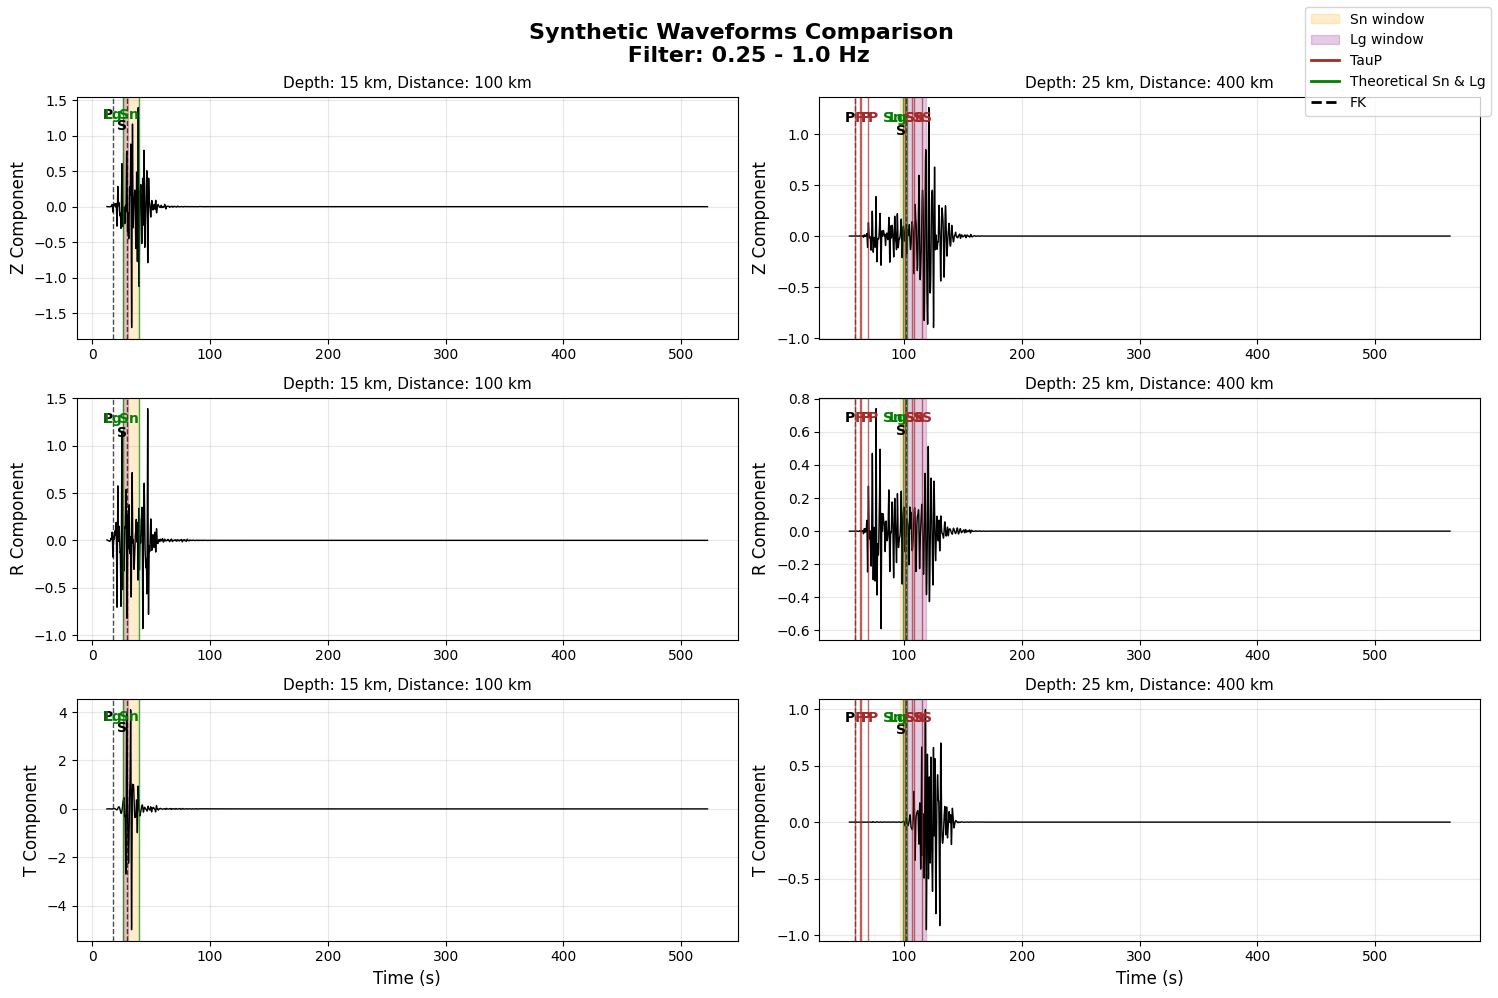

In [14]:
# MODIFY parameters below
depth_index_1 = 0
receiver_index_1 = 0
depth_index_2 = 1
receiver_index_2 = 3
plot_FKArrivals = True
plot_TauP = True
phases = ["Sn", "S", "P", 'Ps']
plot_SnLgArrivals = True

# Get the corresponding depth and distance values
depth_1 = parameters.source_depths[depth_index_1]
receiver_distance_1 = parameters.receiver_distances[receiver_index_1]
depth_2 = parameters.source_depths[depth_index_2]
receiver_distance_2 = parameters.receiver_distances[receiver_index_2]

# Get the streams and SnLg info for these combinations
stream_1 = sync_results[depth_index_1][receiver_index_1]
stream_2 = sync_results[depth_index_2][receiver_index_2]
result_1 = find_result(depth_1, receiver_distance_1, results)
result_2 = find_result(depth_2, receiver_distance_2, results)

# Run TauP
model = TauPyModel(model='Tibetan_model.npz')
deg_1 = kilometers2degrees(receiver_distance_1)
arrivals_1 = model.get_travel_times(source_depth_in_km=depth_1, distance_in_degree=deg_1)
deg_2 = kilometers2degrees(receiver_distance_2)
arrivals_2 = model.get_travel_times(source_depth_in_km=depth_2, distance_in_degree=deg_2)
# print(f'Arrivals for source at {depth_1} km: \n', arrivals_1)
# print(f'Arrivals for source at {depth_2} km: \n', arrivals_2)
# arrivalsPlot_1 = model.get_ray_paths(source_depth_in_km=depth_1, distance_in_degree=deg_1, phase_list=["Sn"])
# arrivalsPlot_1.plot_rays(plot_type='cartesian', phase_list=["Sn"],
#                    plot_all=False, legend=True)
# arrivalsPlot_2 = model.get_ray_paths(source_depth_in_km=depth_2, distance_in_degree=deg_2, phase_list=["S"])
# arrivalsPlot_2.plot_rays(plot_type='cartesian', phase_list=["S"],
#                    plot_all=False, legend=True)

# Create the plot
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle(f'Synthetic Waveforms Comparison \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz', fontsize=16, fontweight='bold')

# Component names and colors
components = ['Z', 'R', 'T']
colors = ['black', 'black', 'black']

for i, (component, color) in enumerate(zip(components, colors)):
    # Left column - Synthetic 1
    ax_left = axes[i, 0]
    trace_1 = process_component(stream_1[i], parameters)
    time_1 = np.arange(len(trace_1)) * trace_1.stats.delta + trace_1.stats.sac.b
    ax_left.plot(time_1, trace_1.data, color=color, linewidth=1)
    ax_left.set_ylabel(f'{component} Component', fontsize=12)
    ax_left.grid(True, alpha=0.3)
    ax_left.set_title(f'Depth: {depth_1} km, Distance: {receiver_distance_1} km', fontsize=11)
    # Shade Sn and Lg windows
    if result_1:
        sn_window, lg_window = result_1[4], result_1[5]
        if sn_window:
            ax_left.axvspan(sn_window[0], sn_window[1], color='orange', alpha=0.2, label='Sn window' if i == 0 else "")
        if lg_window:
            ax_left.axvspan(lg_window[0], lg_window[1], color='purple', alpha=0.2, label='Lg window' if i == 0 else "")
    # Add P and S arrivals
    if plot_FKArrivals:
        if hasattr(trace_1.stats, 'sac'):
            p_time = getattr(trace_1.stats.sac, 't1', None)
            s_time = getattr(trace_1.stats.sac, 't2', None)
            if p_time is not None and p_time != -12345:
                ax_left.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_left.text(p_time, ax_left.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                            horizontalalignment='right', verticalalignment='top')
            if s_time is not None and s_time != -12345:
                ax_left.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_left.text(s_time, ax_left.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
    # Add TauP arrivals
    if plot_TauP:
        for arrival_1 in arrivals_1:
            if arrival_1.name in phases:
                if arrival_1.time < lg_window[1] + 20:
                    # Set color based on arrival name
                    ax_left.axvline(x=arrival_1.time, color='brown', linestyle='-', linewidth=1, alpha=0.7)
                    y_pos = ax_left.get_ylim()[1] * 0.9
                    ax_left.text(arrival_1.time + 0.2, y_pos, arrival_1.name, color='brown', fontweight='bold',
                                verticalalignment='top', horizontalalignment='left', fontsize=10)
    # Add theoretical Sn and Lg arrivals
    if plot_SnLgArrivals:
        if result_1:
            tsn, tlg = result_1[8], result_1[9]
            ax_left.axvline(x=tsn, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_left.text(tsn, ax_left.get_ylim()[1]*0.9, 'Sn', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
            ax_left.axvline(x=tlg, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_left.text(tlg, ax_left.get_ylim()[1]*0.9, 'Lg', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')

    # Right column - Synthetic 2
    ax_right = axes[i, 1]
    trace_2 = process_component(stream_2[i], parameters)
    time_2 = np.arange(len(trace_2)) * trace_2.stats.delta + trace_2.stats.sac.b
    ax_right.plot(time_2, trace_2.data, color=color, linewidth=1)
    ax_right.set_ylabel(f'{component} Component', fontsize=12)
    ax_right.grid(True, alpha=0.3)
    ax_right.set_title(f'Depth: {depth_2} km, Distance: {receiver_distance_2} km', fontsize=11)
    # Shade Sn and Lg windows
    if result_2:
        sn_window, lg_window = result_2[4], result_2[5]
        if sn_window:
            ax_right.axvspan(sn_window[0], sn_window[1], color='orange', alpha=0.2)
        if lg_window:
            ax_right.axvspan(lg_window[0], lg_window[1], color='purple', alpha=0.2)
    # Add P and S arrivals
    if plot_FKArrivals:
        if hasattr(trace_2.stats, 'sac'):
            p_time = getattr(trace_2.stats.sac, 't1', None)
            s_time = getattr(trace_2.stats.sac, 't2', None)
            if p_time is not None and p_time != -12345:
                ax_right.axvline(x=p_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_right.text(p_time, ax_right.get_ylim()[1]*0.9, 'P', color='black', fontweight='bold', 
                            horizontalalignment='right', verticalalignment='top')
            if s_time is not None and s_time != -12345:
                ax_right.axvline(x=s_time, color='black', linestyle='--', linewidth=1, alpha=0.7)
                ax_right.text(s_time, ax_right.get_ylim()[1]*0.8, 'S', color='black', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
    # Add TauP arrivals
    if plot_TauP:
        for arrival_2 in arrivals_2:
            if arrival_2.name in phases:
                if arrival_2.time < lg_window[1] + 20:
                    # Set color based on arrival name
                    ax_right.axvline(x=arrival_2.time, color='brown', linestyle='-', linewidth=1, alpha=0.7)
                    y_pos = ax_right.get_ylim()[1] * 0.9
                    ax_right.text(arrival_2.time + 0.2, y_pos, arrival_2.name, color='brown', fontweight='bold',
                                verticalalignment='top', horizontalalignment='left', fontsize=10)
    # Add theoretical Sn and Lg arrivals
    if plot_SnLgArrivals:
        if result_2:
            tsn, tlg = result_2[8], result_2[9]
            ax_right.axvline(x=tsn, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_right.text(tsn, ax_right.get_ylim()[1]*0.9, 'Sn', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')
            ax_right.axvline(x=tlg, color='green', linestyle='-', linewidth=1, alpha=0.7)
            ax_right.text(tlg, ax_right.get_ylim()[1]*0.9, 'Lg', color='green', fontweight='bold',
                            horizontalalignment='right', verticalalignment='top')

# Set x-axis labels for the bottom subplots
axes[-1, 0].set_xlabel('Time (s)', fontsize=12)
axes[-1, 1].set_xlabel('Time (s)', fontsize=12)

# Add legend
handles, labels = [], []
for ax in [axes[0, 0], axes[0, 1]]:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
custom_lines = [
    Line2D([0], [0], color='brown', lw=2, label='TauP') if plot_TauP else None,
    Line2D([0], [0], color='green', lw=2, label='Theoretical Sn & Lg') if plot_SnLgArrivals else None,
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='FK') if plot_FKArrivals else None,
]
custom_lines = [line for line in custom_lines if line is not None]
if handles:
    fig.legend(handles + custom_lines, labels + [line.get_label() for line in custom_lines], loc='upper right')
else:
    fig.legend(custom_lines, [line.get_label() for line in custom_lines], loc='upper right')

print('Synthetic 1 ln(Sn/Lg):', result_1[2]) # index 2 is raw, 3 is cor
print('Synthetic 2 ln(Sn/Lg):', result_2[2])

plt.tight_layout()
plt.show()


## Plot synthetics versus depth

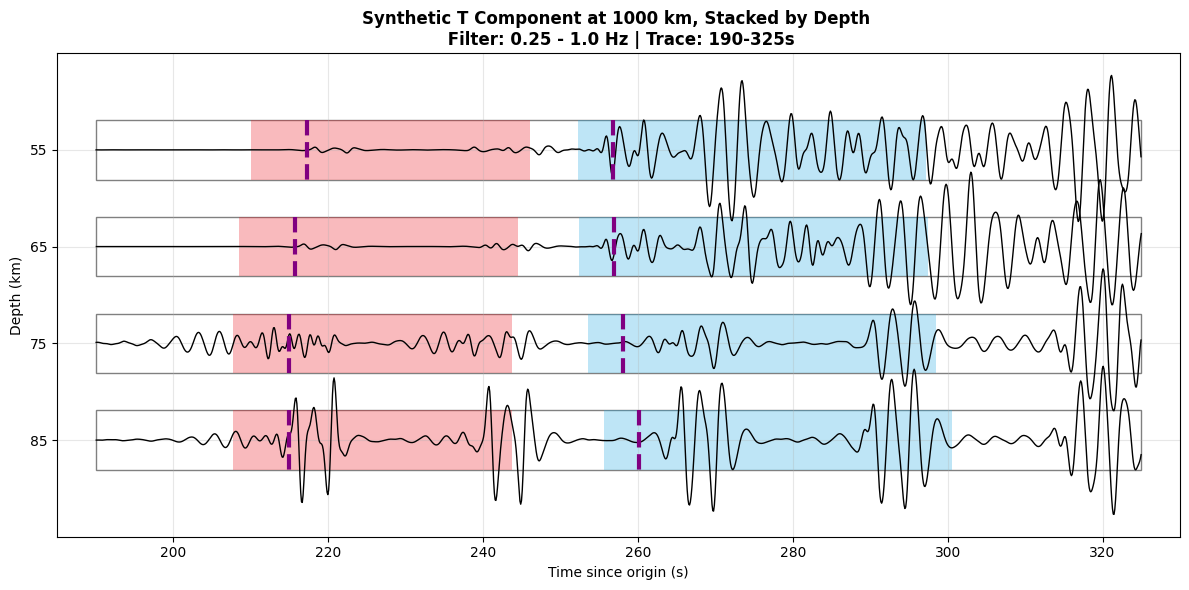

In [15]:
# MODIFY parameters
receiver_index = 9
plot_FKArrivals2 = False
plot_TauP2 = False
phases = ["Sn", "S", "P"]
plot_SnLgArrivals2 = True
trace_start_time = 190  # Start time for the trace portion to plot
trace_end_time = 325    # End time for the trace portion to plot
axes_buffer = 5

# MODIFY: Choose which depths to plot
plot_all_depths = False
selected_depth_indexes = [4, 5, 6, 7]  # To use, set plot_all_depths to False

# Determine which depths to plot
if plot_all_depths:
    depth_indexes_to_plot = list(range(len(sync_results)))
else:
    depth_indexes_to_plot = selected_depth_indexes

n_depths_to_plot = len(depth_indexes_to_plot)
trace_height = 1.3  # vertical space per trace
box_height = 0.8    # height of the box around each trace
fig, ax = plt.subplots(figsize=(12, 1.5 * n_depths_to_plot))

for plot_idx, depth_idx in enumerate(depth_indexes_to_plot):
    # print(f"Depth: {parameters.source_depths[depth_idx]} km, Receiver: {parameters.receiver_distances[receiver_index]} km")
    stream = sync_results[depth_idx][receiver_index]
    tr = process_component(stream[-1], parameters)
    t = np.arange(tr.stats.npts) * tr.stats.delta + tr.stats.sac.b
    data = tr.data / np.max(np.abs(tr.data))
    
    # Filter trace data to only the specified time range
    time_mask = (t >= trace_start_time) & (t <= trace_end_time)
    t_filtered = t[time_mask]
    data_filtered = data[time_mask]
    
    y_base = plot_idx * trace_height  # Use plot_idx instead of depth_idx for positioning
    y_bottom = y_base - box_height/2

    # Draw the main rectangle around the specified trace portion
    if len(t_filtered) > 0:
        rect = Rectangle(
            (trace_start_time, y_bottom),
            trace_end_time - trace_start_time,
            box_height,
            linewidth=1, edgecolor='gray', facecolor='none', zorder=0
        )
        ax.add_patch(rect)

    # Highlight Sn/Lg windows as filled rectangles within the box
    result = find_result(parameters.source_depths[depth_idx], parameters.receiver_distances[receiver_index], results)
    if result:
        sn_window, lg_window = result[4], result[5]
        if sn_window:
            # Only plot Sn window if it falls within the trace time range
            sn_start = max(sn_window[0], trace_start_time)
            sn_end = min(sn_window[1], trace_end_time)
            if sn_end > sn_start:
                sn_rect = Rectangle(
                    (sn_start, y_bottom),
                    sn_end - sn_start,
                    box_height,
                    linewidth=0, facecolor='#ed1c25', alpha=0.3, zorder=1,
                )
                ax.add_patch(sn_rect)
        if lg_window:
            # Only plot Lg window if it falls within the trace time range
            lg_start = max(lg_window[0], trace_start_time)
            lg_end = min(lg_window[1], trace_end_time)
            if lg_end > lg_start:
                lg_rect = Rectangle(
                    (lg_start, y_bottom),
                    lg_end - lg_start,
                    box_height,
                    linewidth=0, facecolor='#29abe2', alpha=0.3, zorder=1,
                )
                ax.add_patch(lg_rect)

    # Plot the trace, vertically offset (only the specified portion)
    if len(t_filtered) > 0:
        ax.plot(t_filtered, data_filtered + y_base, color='black', linewidth=1, zorder=2)

    # Add FK arrivals (only if they fall within the trace time range)
    if plot_FKArrivals2:
        if hasattr(tr.stats, 'sac'):
            t1 = tr.stats.sac.t1 if hasattr(tr.stats.sac, 't1') else None
            t2 = tr.stats.sac.t2 if hasattr(tr.stats.sac, 't2') else None
            if t1 is not None and t1 != -12345 and trace_start_time <= t1 <= trace_end_time:
                ax.vlines(t1, y_bottom, y_bottom + box_height, color='black', linestyle='--', linewidth=1, zorder=3)
                ax.text(t1 + .3, y_base, 'P', color='black', fontsize=10, ha='left', va='bottom', zorder=4)
            if t2 is not None and t2 != -12345 and trace_start_time <= t2 <= trace_end_time:
                ax.vlines(t2, y_bottom, y_bottom + box_height, color='black', linestyle='--', linewidth=1, zorder=3)
                ax.text(t2 + .3, y_base, 'S', color='black', fontsize=10, ha='left', va='bottom', zorder=4)
    
    # Add theoretical Sn and Lg arrivals (only if they fall within the trace time range)
    if plot_SnLgArrivals2:
        if result:
            tsn, tlg = result[8], result[9]
            if trace_start_time <= tsn <= trace_end_time:
                ax.vlines(tsn, y_bottom, y_bottom + box_height, color='purple', linestyle='--', linewidth=3, zorder=3)
                # ax.text(tsn + .3, y_base, 'Sn', color='green', fontsize=10, ha='left', va='bottom', zorder=4)
            if trace_start_time <= tlg <= trace_end_time:
                ax.vlines(tlg, y_bottom, y_bottom + box_height, color='purple', linestyle='--', linewidth=3, zorder=3)
                # ax.text(tlg + .3, y_base, 'Lg', color='green', fontsize=10, ha='left', va='bottom', zorder=4)
    
    # Add TauP arrivals (only if they fall within the trace time range)
    deg_all = kilometers2degrees(parameters.receiver_distances[receiver_index])
    arrivals_per_depth = model.get_travel_times(source_depth_in_km=parameters.source_depths[depth_idx], distance_in_degree=deg_all)
    if plot_TauP2:
        for arrival in arrivals_per_depth:
            if arrival.name in phases:
                # Check if arrival time is within the trace time range
                if (trace_start_time <= arrival.time <= trace_end_time and 
                    result and lg_window and arrival.time < lg_window[1] + 20):
                    ax.vlines(arrival.time, y_bottom, y_bottom + box_height, color='brown', linestyle='-', linewidth=1, zorder=3)
                    ax.text(arrival.time + .3, y_base, arrival.name, color='brown', fontsize=10, ha='left', va='bottom', zorder=4)

# Set y-limits to fit all traces with a little padding
ax.set_ylim(-trace_height, n_depths_to_plot * trace_height)
ax.set_yticks([i * trace_height for i in range(n_depths_to_plot)])
# Create labels for the selected depths
depth_labels = [f"{parameters.source_depths[idx]}" for idx in depth_indexes_to_plot]
ax.set_yticklabels(depth_labels)
ax.invert_yaxis()  # Depth increases downward

# Set x-axis limits with buffer around the rectangle
axes_start = trace_start_time - axes_buffer
axes_end = trace_end_time + axes_buffer
ax.set_xlim(axes_start, axes_end)

ax.set_xlabel("Time since origin (s)")
ax.set_ylabel("Depth (km)")
ax.set_title(f"Synthetic T Component at {parameters.receiver_distances[receiver_index]} km, Stacked by Depth \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz | Trace: {trace_start_time}-{trace_end_time}s", fontweight='bold')
ax.grid(True, alpha=0.3)

# --- Add custom legend ---
custom_lines = [
    Patch(facecolor='orange', edgecolor='orange', alpha=0.3, label='Sn window'),
    Patch(facecolor='purple', edgecolor='purple', alpha=0.3, label='Lg window'),
    Line2D([0], [0], color='brown', lw=2, label='TauP (phases)') if plot_TauP2 else None,
    Line2D([0], [0], color='green', lw=2, linestyle = '--', label='Sn & Lg arrivals') if plot_SnLgArrivals2 else None,
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='FK (P/S arrivals)') if plot_FKArrivals2 else None,
]
custom_lines = [line for line in custom_lines if line is not None]
# ax.legend(handles=custom_lines, loc='upper left')
plt.tight_layout()
plt.show()

## Plot synthetics versus distance

Slope for FK P: 8.50002 km/s
Slope for FK S: 4.84065 km/s
Slope for TauP P: 8.70571 km/s
Slope for TauP S: 4.95784 km/s


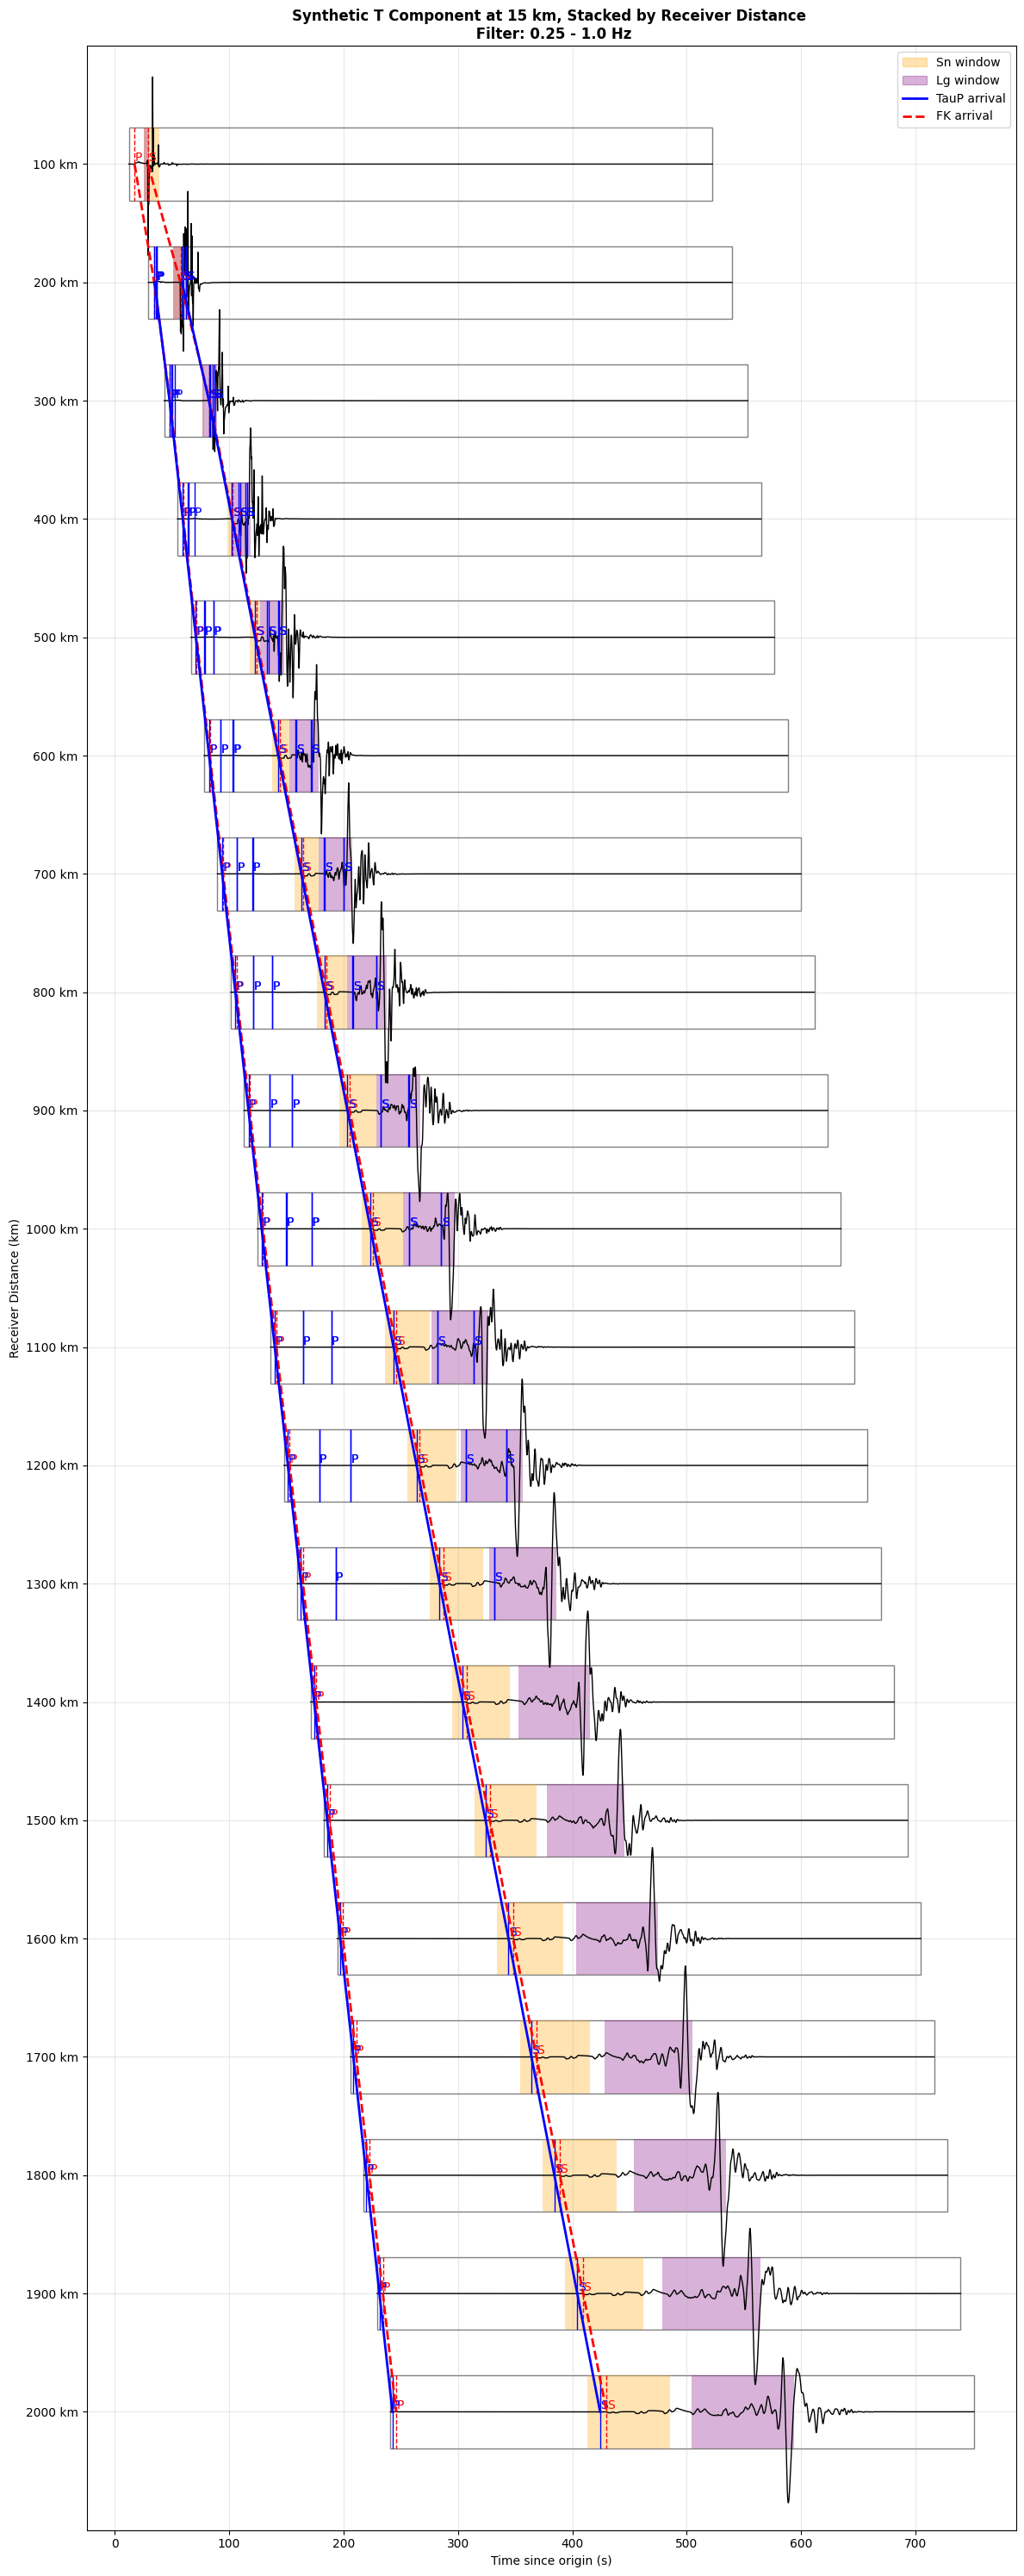

In [16]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np

# MODIFY to choose depth
depth_index = 0
plot_FKArrivals3 = True
plot_TauP3 = True
plot_SnLgArrivals3 = False
plot_lines = True

n_receivers = len(parameters.receiver_distances)
trace_height = 1.3  # vertical space per trace
box_height = 0.8    # height of the box around each trace
fig, ax = plt.subplots(figsize=(12, 1.5 * n_receivers))

# Store the y_base (vertical position) and arrival times for each receiver
fk_p_arrival_time, fk_s_arrival_time = [], []
taup_p_arrival_time, taup_s_arrival_time = [], []
y_positions = []

for receiver_idx in range(n_receivers):
    stream = sync_results[depth_index][receiver_idx]
    tr = stream[-1]
    t = np.arange(tr.stats.npts) * tr.stats.delta + tr.stats.sac.b
    data = tr.data / np.max(np.abs(tr.data))
    y_base = receiver_idx * trace_height
    y_bottom = y_base - box_height/2
    y_positions.append(y_base)

    # Draw the main rectangle for this trace
    rect = Rectangle(
        (t[0], y_bottom),
        t[-1] - t[0],
        box_height,
        linewidth=1, edgecolor='gray', facecolor='none', zorder=0
    )
    ax.add_patch(rect)

    # Highlight Sn/Lg windows as filled rectangles within the box
    result = find_result(parameters.source_depths[depth_index], parameters.receiver_distances[receiver_idx], results)
    if result:
        sn_window, lg_window = result[4], result[5]
        if sn_window:
            sn_rect = Rectangle(
                (sn_window[0], y_bottom),
                sn_window[1] - sn_window[0],
                box_height,
                linewidth=0, facecolor='orange', alpha=0.3, zorder=1,
            )
            ax.add_patch(sn_rect)
        if lg_window:
            lg_rect = Rectangle(
                (lg_window[0], y_bottom),
                lg_window[1] - lg_window[0],
                box_height,
                linewidth=0, facecolor='purple', alpha=0.3, zorder=1,
            )
            ax.add_patch(lg_rect)

    # Plot the trace, vertically offset
    ax.plot(t, data + y_base, color='black', linewidth=1, zorder=2)

    # Add FK arrivals and store for connecting lines
    fk_p, fk_s = float('nan'), float('nan')
    if plot_FKArrivals3:
        if hasattr(tr.stats, 'sac'):
            t1 = tr.stats.sac.t1 if hasattr(tr.stats.sac, 't1') else None
            t2 = tr.stats.sac.t2 if hasattr(tr.stats.sac, 't2') else None
            if t1 is not None and t1 != -12345:
                ax.vlines(t1, y_bottom, y_bottom + box_height, color='red', linestyle='--', linewidth=1, zorder=3)
                ax.text(t1 + .3, y_base, 'P', color='red', fontsize=10, ha='left', va='bottom', zorder=4)
                fk_p = t1
            if t2 is not None and t2 != -12345:
                ax.vlines(t2, y_bottom, y_bottom + box_height, color='red', linestyle='--', linewidth=1, zorder=3)
                ax.text(t2 + .3, y_base, 'S', color='red', fontsize=10, ha='left', va='bottom', zorder=4)
                fk_s = t2
    fk_p_arrival_time.append(fk_p)
    fk_s_arrival_time.append(fk_s)
    # Add theoretical Sn and Lg arrivals
    if plot_SnLgArrivals3:
        if result:
            tsn, tlg = result[8], result[9]
            ax.vlines(tsn, y_bottom, y_bottom + box_height, color='green', linestyle='-', linewidth=1, zorder=3)
            ax.vlines(tlg, y_bottom, y_bottom + box_height, color='green', linestyle='-', linewidth=1, zorder=3)
            ax.text(tsn + .3, y_base, 'Sn', color='green', fontsize=10, ha='left', va='bottom', zorder=4)
            ax.text(tlg + .3, y_base, 'Lg', color='green', fontsize=10, ha='left', va='bottom', zorder=4)
    # Add TauP arrivals and store for connecting lines
    taup_p, taup_s = float('nan'), float('nan')
    deg_all = kilometers2degrees(parameters.receiver_distances[receiver_idx])
    arrivals_per_receiver = model.get_travel_times(
        source_depth_in_km=parameters.source_depths[depth_index],
        distance_in_degree=deg_all
    )
    if plot_TauP3:
        found_p = False
        found_s = False
        for arrival in arrivals_per_receiver:
            if arrival.name == 'P':
                if result and lg_window and arrival.time < lg_window[1] + 20:
                    # Plot all P arrivals
                    ax.vlines(arrival.time, y_bottom, y_bottom + box_height, color='blue', linestyle='-', linewidth=1, zorder=3)
                    ax.text(arrival.time + .3, y_base, arrival.name, color='blue', fontsize=10, ha='left', va='bottom', zorder=4)
                    # Store only the first P for connecting line
                    if not found_p:
                        taup_p = arrival.time
                        found_p = True
            if arrival.name == 'S':
                if result and lg_window and arrival.time < lg_window[1] + 20:
                    # Plot all S arrivals
                    ax.vlines(arrival.time, y_bottom, y_bottom + box_height, color='blue', linestyle='-', linewidth=1, zorder=3)
                    ax.text(arrival.time + .3, y_base, arrival.name, color='blue', fontsize=10, ha='left', va='bottom', zorder=4)
                    # Store only the first S for connecting line
                    if not found_s:
                        taup_s = arrival.time
                        found_s = True
            
    taup_p_arrival_time.append(taup_p)
    taup_s_arrival_time.append(taup_s)

# Set y-limits to fit all traces with a little padding
ax.set_ylim(-trace_height, n_receivers * trace_height)
ax.set_yticks([i * trace_height for i in range(n_receivers)])
ax.set_yticklabels([f"{d} km" for d in parameters.receiver_distances])
ax.invert_yaxis()  # Receiver distance increases downward

ax.set_xlabel("Time since origin (s)")
ax.set_ylabel("Receiver Distance (km)")
ax.set_title(f"Synthetic T Component at {parameters.source_depths[depth_index]} km, Stacked by Receiver Distance \n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz", fontweight='bold')
ax.grid(True, alpha=0.3)

# --- Add custom legend ---
custom_lines = [
    Patch(facecolor='orange', edgecolor='orange', alpha=0.3, label='Sn window'),
    Patch(facecolor='purple', edgecolor='purple', alpha=0.3, label='Lg window'),
    Line2D([0], [0], color='blue', lw=2, label='TauP arrival') if plot_TauP3 else None,
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='FK arrival') if plot_FKArrivals3 else None,
]
custom_lines = [line for line in custom_lines if line is not None]
ax.legend(handles=custom_lines, loc='upper right')

# --- Connect the FK and TauP arrivals across receivers ---
y_positions = np.array(y_positions)
fk_p_arrival_time = np.array(fk_p_arrival_time)
fk_s_arrival_time = np.array(fk_s_arrival_time)
taup_p_arrival_time = np.array(taup_p_arrival_time)
taup_s_arrival_time = np.array(taup_s_arrival_time)

if plot_lines:
    # Only plot where not nan
    if plot_FKArrivals3:
        mask_fk_p = ~np.isnan(fk_p_arrival_time)
        mask_fk_s = ~np.isnan(fk_s_arrival_time)
        ax.plot(fk_p_arrival_time[mask_fk_p], y_positions[mask_fk_p], color='red', lw=2, linestyle='--', zorder=10)
        ax.plot(fk_s_arrival_time[mask_fk_s], y_positions[mask_fk_s], color='red', lw=2, linestyle='--', zorder=10)
    if plot_TauP3:
        mask_taup_p = ~np.isnan(taup_p_arrival_time)
        mask_taup_s = ~np.isnan(taup_s_arrival_time)
        ax.plot(taup_p_arrival_time[mask_taup_p], y_positions[mask_taup_p], color='blue', lw=2, zorder=10)
        ax.plot(taup_s_arrival_time[mask_taup_s], y_positions[mask_taup_s], color='blue', lw=2, zorder=10)

# Compute and print slopes
def compute_slope(arrival_times, receiver_distances, label):
    mask = ~np.isnan(arrival_times)
    if np.sum(mask) > 1:
        # Fit a line: arrival_time = slope * receiver_distance + intercept
        slope, intercept = np.polyfit(receiver_distances[mask], arrival_times[mask], 1)
        slope = 1/slope
        print(f"Slope for {label}: {slope:.5f} km/s")
        return slope
    else:
        print(f"Not enough points to compute slope for {label}")
        return np.nan

receiver_distances = np.array(parameters.receiver_distances)
compute_slope(fk_p_arrival_time, receiver_distances, "FK P")
compute_slope(fk_s_arrival_time, receiver_distances, "FK S")
compute_slope(taup_p_arrival_time, receiver_distances, "TauP P")
compute_slope(taup_s_arrival_time, receiver_distances, "TauP S")

plt.tight_layout()
plt.show()

# Plot results

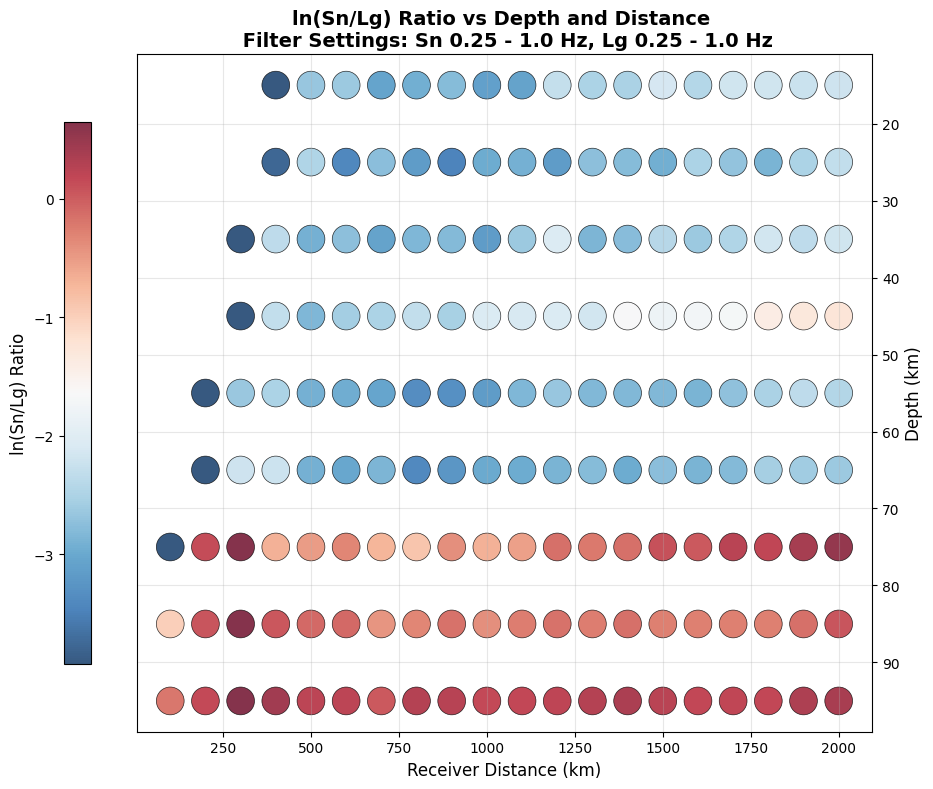

Total data points: 180
Valid ratios: 168
Missing ratios: 12
Moho depth: 70.0 km


In [17]:
# Extract data for plotting
depths = []
receiver_distances = []
ratios = []
sn_amps = []
lg_amps = []

for result in results:
    depth, receiver_distance, snlg_raw, snlg_cor, sn_window, lg_window, amp_sn, amp_lg, tsn, tlg = result
    depths.append(depth)
    receiver_distances.append(receiver_distance)
    ratios.append(snlg_raw) # use raw or cor
    sn_amps.append(amp_sn)
    lg_amps.append(amp_lg)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Separate data points with valid ratios and None ratios
valid_indices = [i for i, ratio in enumerate(ratios) if ratio is not None]
none_indices = [i for i, ratio in enumerate(ratios) if ratio is None]

# Plot valid ratio points with color mapping
if valid_indices:
    valid_depths = [depths[i] for i in valid_indices]
    valid_distances = [receiver_distances[i] for i in valid_indices]
    valid_ratios = [ratios[i] for i in valid_indices]
    
    # Calculate the average ratio between the two depths that bookend the Moho depth
    moho_depth = parameters.moho[0]
    source_depths = parameters.source_depths 
    depths_below_moho = [d for d in source_depths if d < moho_depth]
    depths_above_moho = [d for d in source_depths if d > moho_depth]
    depth_below_moho = max(depths_below_moho) 
    depth_above_moho = min(depths_above_moho)
    
    # Calculate average ratio for these two depths across all receiver distances
    moho_bookend_ratios = []
    for result in results:
        depth, receiver_distance, snlg_raw, snlg_cor, sn_window, lg_window, amp_sn, amp_lg, tsn, tlg = result
        if depth in [depth_below_moho, depth_above_moho] and snlg_raw is not None:
            moho_bookend_ratios.append(snlg_raw)
    neutral_value = np.mean(moho_bookend_ratios) if moho_bookend_ratios else 0.0
    max_deviation = max(abs(max(valid_ratios) - neutral_value), abs(min(valid_ratios) - neutral_value))
    
    # Use full range for colorbar but saturated range for plotting
    saturation_factor = 0.5
    vmin_plot = neutral_value - (max_deviation * saturation_factor)
    vmax_plot = neutral_value + (max_deviation * saturation_factor)
    vmin_cbar = neutral_value - max_deviation
    vmax_cbar = neutral_value + max_deviation
    
    # Create scatter plot with color mapping centered on the neutral value (saturated)
    scatter = ax.scatter(valid_distances, valid_depths, 
                        c=valid_ratios, 
                        cmap='RdBu_r',  # Red-Blue diverging colormap (red=high, blue=low)
                        s=400,  # Marker size
                        edgecolors='black',  # Black edges
                        linewidth=0.5,
                        alpha=0.8,
                        vmin=vmin_plot, 
                        vmax=vmax_plot)  
    
    # Add colorbar to the left
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, location='left', pad = 0.05)
    cbar.set_label('ln(Sn/Lg) Ratio', fontsize=12)
    
    # Add a horizontal line at the neutral value
    # cbar.ax.axhline(y=neutral_value, color='black', linestyle='--', linewidth=2, alpha=0.7)
    
    # # Label each valid point with its ratio value
    # for x, y, ratio in zip(valid_distances, valid_depths, valid_ratios):
    #     ax.text(x, y - 1, f"{ratio:.2f}", fontsize=8, ha='center', va='bottom', color='black')

# Plot None ratio points in gray
if none_indices:
    none_depths = [depths[i] for i in none_indices]
    none_distances = [receiver_distances[i] for i in none_indices]
    
    ax.scatter(none_distances, none_depths, 
              c='white', 
              s=100, 
              edgecolors='white',
              linewidth=0.5,
              alpha=0.8,
              label='No ratio available')

# Customize the plot
ax.set_xlabel('Receiver Distance (km)', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_title(f'ln(Sn/Lg) Ratio vs Depth and Distance \n Filter Settings: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz, Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Move depth axis labels to the right
ax.yaxis.set_label_position('right')
ax.yaxis.tick_right()

# Plot
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total data points: {len(results)}")
print(f"Valid ratios: {len(valid_indices)}")
print(f"Missing ratios: {len(none_indices)}")
print(f"Moho depth: {moho_depth} km")

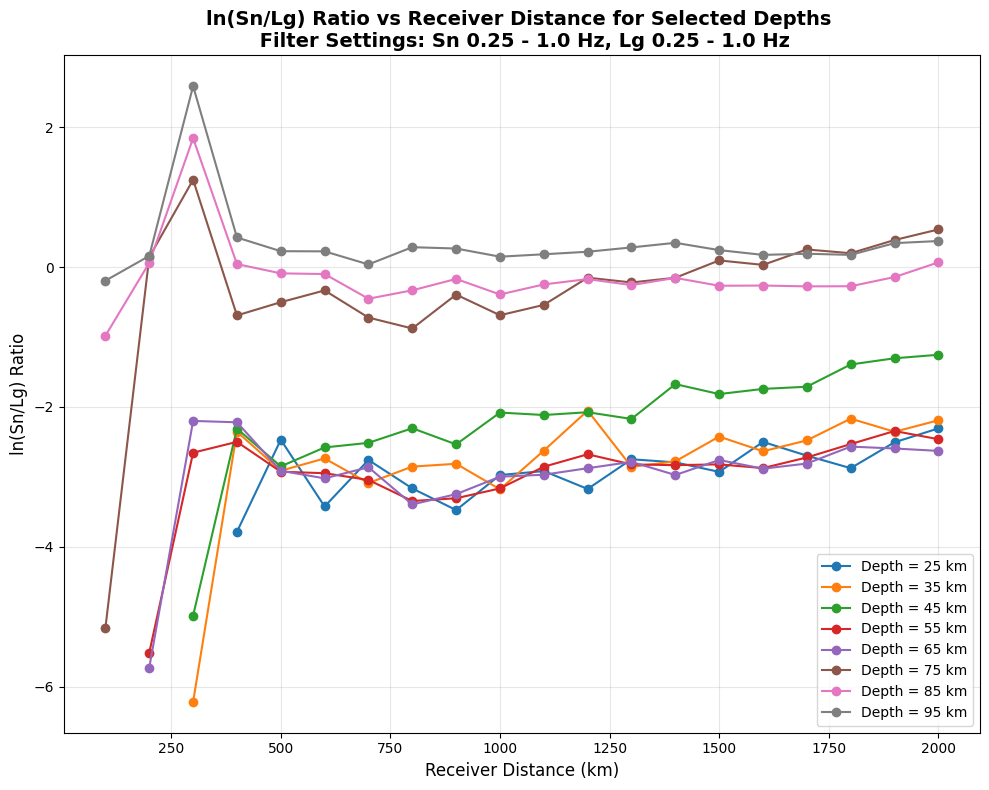

In [18]:
# Choose up to 8 depth indexes
selected_indices = [1, 2, 3, 4, 5, 6, 7, 8] 

# Prepare data
depths = np.array(depths) # Convert arrays to numpy arrays
receiver_distances = np.array(receiver_distances)
ratios = np.array(ratios)
unique_depths = np.unique(depths) # Get unique sorted depths
selected_depths = unique_depths[selected_indices]

# Plotting
plt.figure(figsize=(10, 8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

for i, depth in enumerate(selected_depths):
    mask = (depths == depth) & (ratios != None)
    if np.any(mask):
        plt.plot(receiver_distances[mask], ratios[mask], 
                 marker='o', linestyle='-', color=colors[i], 
                 label=f'Depth = {depth} km')
        # # Annotate points
        # for x, y in zip(receiver_distances[mask], ratios[mask]):
        #     plt.text(x, y + .05, f"{y:.2f}", fontsize=8, ha='center', va='bottom', color=colors[i])

plt.xlabel('Receiver Distance (km)', fontsize=12)
plt.ylabel('ln(Sn/Lg) Ratio', fontsize=12)
plt.title(f'ln(Sn/Lg) Ratio vs Receiver Distance for Selected Depths \n Filter Settings: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz, Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

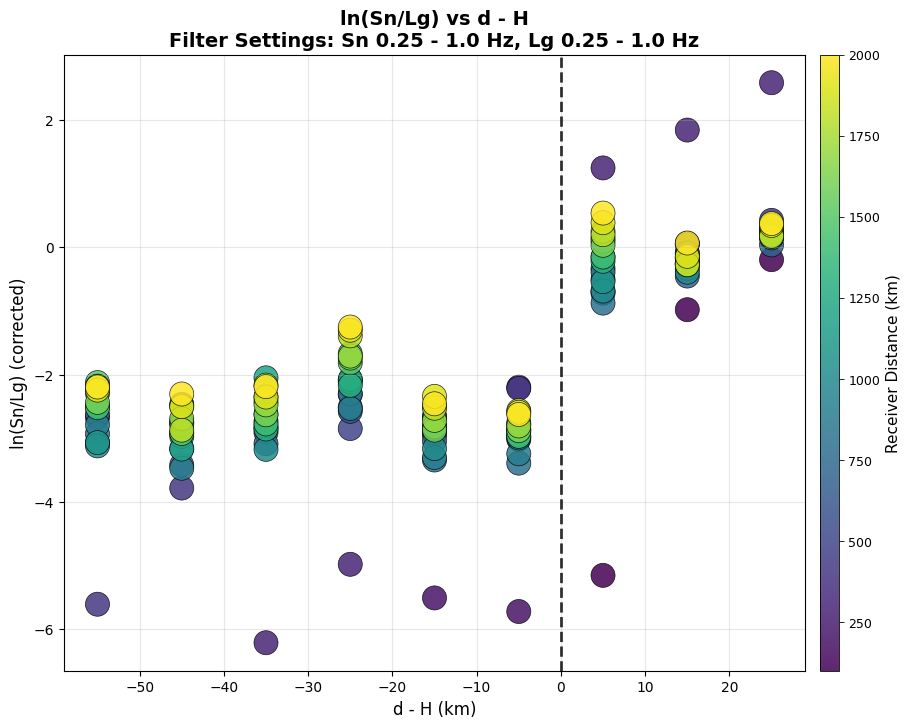

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

H = 70.0  # fixed Moho depth (km)

# Prepare arrays from `results`
depths = []
receiver_distances = []
ratios_cor = []

for result in results:
	depth, receiver_distance, snlg_raw, snlg_cor, sn_window, lg_window, amp_sn, amp_lg, tsn, tlg = result
	depths.append(depth)
	receiver_distances.append(receiver_distance)
	ratios_cor.append(snlg_raw)

depths = np.array(depths, dtype=float)
receiver_distances = np.array(receiver_distances, dtype=float)
ratios_cor = np.array(ratios_cor, dtype=float)  # corrected ln(Sn/Lg)

# Compute d - H
d_minus_H = depths - H

# Valid mask
valid_mask = np.isfinite(ratios_cor) & np.isfinite(receiver_distances) & np.isfinite(d_minus_H)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

if np.any(valid_mask):
	# Color scaling by receiver distance (min→max across valid points)
	cmin = float(np.nanmin(receiver_distances[valid_mask]))
	cmax = float(np.nanmax(receiver_distances[valid_mask]))
	if not np.isfinite(cmin): cmin = 0.0
	if not np.isfinite(cmax) or cmax == cmin: cmax = cmin + 1e-6

	scatter = ax.scatter(
		d_minus_H[valid_mask],
		ratios_cor[valid_mask],
		c=receiver_distances[valid_mask],
		cmap='viridis',
		vmin=cmin,
		vmax=cmax,
		s=300,
		edgecolors='black',
		linewidth=0.5,
		alpha=0.85
	)

	# Slim, non-overlapping colorbar to the right
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="2.5%", pad=0.15)
	cbar = fig.colorbar(scatter, cax=cax)
	cbar.set_label('Receiver Distance (km)', fontsize=11)
	cbar.ax.tick_params(labelsize=9, width=0.6)
	cbar.outline.set_linewidth(0.6)

# Dashed vertical line at d - H = 0
ax.axvline(x=0.0, color='black', linestyle='--', linewidth=2, alpha=0.8)

# Labels and styling
ax.set_xlabel('d - H (km)', fontsize=12)
ax.set_ylabel('ln(Sn/Lg) (corrected)', fontsize=12)
ax.set_title(
	f'ln(Sn/Lg) vs d - H\n'
	f'Filter Settings: Sn {parameters.Sn_freqmin} - {parameters.Sn_freqmax} Hz, '
	f'Lg {parameters.Lg_freqmin} - {parameters.Lg_freqmax} Hz',
	fontsize=14,
	fontweight='bold'
)
ax.grid(True, alpha=0.3)

plt.show()